# Introduction:
The term “range anxiety” describes the vast tendency many new car buyers have when becoming prospective electric vehicle (EV) owners. This stems from the fear that drivers will run out of electricity before they can find a charging station. This project targets "range anxiety" among potential EV owners by finding routes that can show routes optimized to finding the least amount of charge stations to get from LA to New York. <br>
The project focuses on a minimum-cost flow network problem with the goal of have finding the shortest path between destinations while 
requiring there to be enough charge stations between destinations. <br> 


# Model and Approach
The approach started with developing a min-cost flow network problem by considering only the cost of "distances". A small scale of 10 randomly sampled charge stations in the LA area were selected. Distances were measured in euclidian distances. The greatest challenge was handling the memory consumption of billions of arcs. With several points of weakness in this project for bugs: python syntax, GAMS syntax, model design, etc, memory issues was the least expected challenge. <br>
The method starts with filtering locations that deviated to far from a direct line that ran between LA and NYC. This created a corridor. A KMeans algorithm was then implemented to create labelled data based on clusters. The number of clusters, the number of locations sampled per cluster, and the threshold for sampling in a cluster are parameters created and used to control the amound of nodes and arcs that had to be computed. Networks with more then 4000 nodes were computationally impossible as GAMS would complain about running out of memory. <br>
Lastly, electric vehicles with ranges from 92 to 900 km are allowed and accounted for. This data was gathered from the secondary data set mentioned in the project spec. These vehicle range parameters are used to enable or disable arcs: if an node is further then the range of the vehicle, the arc connecting the two nodes would be zero and filtered out in the model.

## Importations

In [1]:
!pip install -U scikit-learn
!pip install geopy
!pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from geopy.distance import great_circle
path = 'ElectricCarData_Clean.csv'
df = pd.read_csv(path)

In [3]:
df['Range_Km'].describe()

count    103.000000
mean     338.786408
std      126.014444
min       95.000000
25%      250.000000
50%      340.000000
75%      400.000000
max      970.000000
Name: Range_Km, dtype: float64

## Some function declarations

In [4]:
def distance(lat1, lon1, lat2, lon2, max_range = 92):
    delX = np.abs(lon1-lon2)
    delY = np.abs(lat1-lat2)

    mag = np.sqrt((delX**2) + (delY**2))*111
    mag[mag > max_range] = 0

    return mag

def net_gen(df, max_range):
    latitudes = df['latitude'].values
    longitudes = df['longitude'].values

    # Creating a distance matrix using vectorized distance formula
    dist_matrix = distance(latitudes[:, np.newaxis], longitudes[:, np.newaxis], latitudes, longitudes, max_range=max_range)

    # Fill diagonal with 0s (distance to itself)
    np.fill_diagonal(dist_matrix, 0)

    # Convert the distance matrix to a DataFrame
    df_net = pd.DataFrame(dist_matrix, index=df.index, columns=df.index)
    
    return df_net

# Function to find the shortest distance from a point to a line given by two points (x1, y1) and (x2, y2)
def point_to_line_distance(x, y, x1, y1, x2, y2):
    # Line coefficients a, b, c (from the general equation of the line ax + by + c = 0)
    a = y2 - y1
    b = x1 - x2
    c = (y1 - y2)*x1 + (x2 - x1)*y1

    # Using the line distance formula
    dist = abs(a*x + b*y + c) / np.sqrt(a**2 + b**2)
    return dist

## Data Preprocessing: Cleaning, Filtering, Sampling, and Network Construction

Short Range vehicle


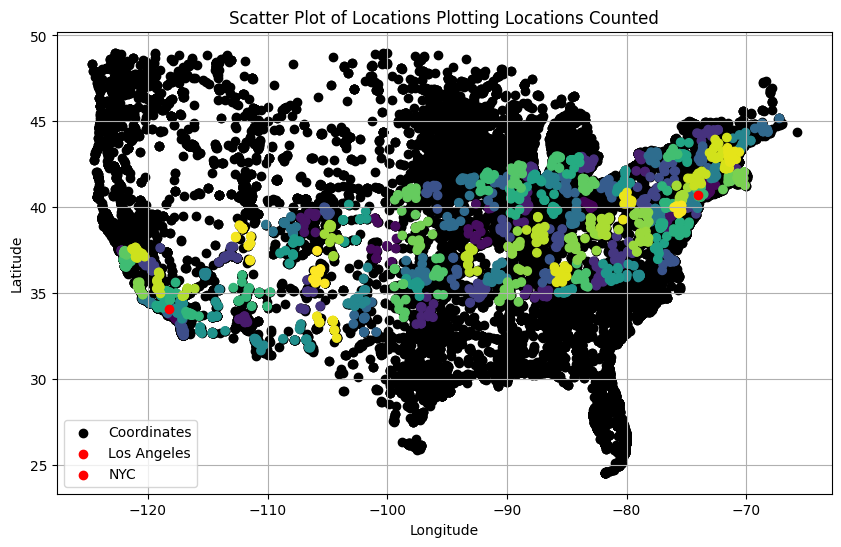

(1802, 81)

In [5]:
vehicle_range = 228
public_station = False
    
if vehicle_range <= 130:
    print("Below minimum vehicle range")
    num_clusters = 150
    max_group = 30 # large clusters cap
    group_cap = 45 # Small clusters tolerance
elif vehicle_range < 250:
    print("Short Range vehicle")
    num_clusters = 120
    max_group = 15 # large clusters cap
    group_cap = 25 # Small clusters tolerance
elif vehicle_range < 450:
    print("Medium-low range vehicle")
    num_clusters = 60
    max_group = 10 # large clusters cap
    group_cap = 10 # Small clusters tolerance
elif vehicle_range < 700:
    print("Medium Range vehicle")  
    num_clusters = 40
    max_group = 10 # large clusters cap
    group_cap = 5 # Small clusters tolerance
elif vehicle_range <= 900:
    print("Long Range vehicle") 
    num_clusters = 15
    max_group = 20 # large clusters cap
    group_cap = 5 # Small clusters tolerance
else:
    print("Above maximum vehicle range")
    num_clusters = 100
    max_group = 5 # large clusters cap
    group_cap = 5 # Small clusters tolerance

path = 'Alternative_Fueling_Stations.csv'
df = pd.read_csv(path, low_memory = False)

# Define the longitude and latitude range
lon_min, lon_max = -150, 20
lat_min, lat_max = 20, 50

# Filter rows where longitude is between -150 and 50, and latitude is between 20 and 50
df_filtered = df[(df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) &
                 (df['latitude'] >= lat_min) & (df['latitude'] <= lat_max)]
condition = df_filtered['groups_with_access_code'].str.contains('public', case=False, na=False)
df_filtered.loc[condition, 'groups_with_access_code'] = 'public'
if public_station:
    df_US = df_filtered[df_filtered['groups_with_access_code'] == 'public']
else:
    df_US = df_filtered.copy()

la_lon, la_lat = -118.2426, 34.0549
nyc_lon, nyc_lat = -74.0060, 40.7128

km_per_degree = 111  # average value, can vary based on latitude

# Assuming 7 km is the corridor half-width
corridor_half_width_km = 7
corridor_width_degrees = 4# corridor_half_width_km / km_per_degree  # convert half-width to degrees

# Filter the DataFrame to get only locations within the corridor
df_corridor = df_US.copy()
df_corridor['distance_to_line'] = df_corridor.apply(
    lambda row: point_to_line_distance(row['longitude'], row['latitude'], la_lon, la_lat, nyc_lon, nyc_lat), axis=1
)
df_corridor = df_corridor[df_corridor['distance_to_line'] <= corridor_width_degrees]

# Make clusters of locations
model = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df_corridor['predictions'] = model.fit_predict(df_corridor[['latitude', 'longitude']])

# Samples 2 samples 10 from high density clusters and samples all in low density clusters
samples2 = pd.concat([df_group if len(df_group) < group_cap else df_group.sample(n=max_group) 
                      for _, df_group in df_corridor.groupby('predictions')])
final_df = samples2.copy()
NYC_sample = df_US.loc[[17191]]
LA_sample = df_US.loc[[29041]]


if 17191 not in np.array(samples2.index):
    final_df = pd.concat([final_df, NYC_sample])
    
if 29041 not in samples2.index:
    final_df = pd.concat([final_df, LA_sample])
    
# Step 3: Concatenate everything into one DataFrame
df_final = final_df.copy()
arc_net = net_gen(df_final, max_range= vehicle_range)
for col in arc_net.select_dtypes(include=['float64']).columns:
    arc_net[col] = pd.to_numeric(arc_net[col], downcast='float')

# final_df now contains only the points within the corridor
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['longitude'], df_filtered['latitude'], label='Coordinates', c='k')
plt.scatter(final_df['longitude'], final_df['latitude'], c = final_df['predictions'])
plt.scatter(la_lon, la_lat, color='red', label='Los Angeles')
plt.scatter(nyc_lon, nyc_lat, color='red', label='NYC')

# Finalize and show the plot
title = 'Scatter Plot of Locations Plotting Locations Counted'
plt.title(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()
final_df.shape

## GAMS

In [6]:
df = arc_net
%load_ext gams.magic
m = gams.exchange_container
stackdf = df.stack().reset_index()
nodes = m.addSet('nodes', description = "nodes", records = df.index)
distances = m.addParameter('distances', [nodes, nodes], records = stackdf)

c:\Users\shiha\anaconda3\envs\gams\lib\site-packages\gams\transfer\containers\_container.py:73: UserWarning: The GAMS version (44.3.0) differs from the API version (47.1.0).
  ws = GamsWorkspace()
c:\Users\shiha\anaconda3\envs\gams\lib\site-packages\gams\core\numpy\gams2numpy.py:45: UserWarning: The GAMS version (44.3.0) differs from the API version (47.1.0).
  ws = GamsWorkspace(system_directory=system_directory)
c:\Users\shiha\anaconda3\envs\gams\lib\site-packages\gams\magic\interactive.py:374: UserWarning: The GAMS version (44.3.0) differs from the API version (47.1.0).
  self._ws = GamsWorkspace(".", system_directory)


In [7]:
%%gams
alias(i, j, nodes)
parameter supply(nodes) /29041 1, 17191 -1/;

set arcs(nodes, nodes);
arcs(i,j) = distances(i,j) > 0;
* Variables for the optimization problem
* Variable for total distance
variables totalDistance;
* Flow variables for each arc      
positive variables x(nodes,nodes) flow; 

* Equations for constraints and objective
equations balance(nodes), objective;

* Balance equation for flow conservation
balance(nodes)..
    sum(arcs(nodes,j), x(nodes,j)) - sum(arcs(i,nodes), x(i,nodes)) =e= supply(nodes);

* Objective function for total distance minimization
objective..
    totalDistance =e= sum(arcs, distances(arcs) * x(arcs));

* Model definition
model short1 / balance, objective /;

* Packaging to send to NEOs via kestrel solver
short1.optfile=1;
option lp=kestrel;
solve short1 minimizing totalDistance using lp;
$echo email shih.andrew@outlook.com > kestrel.opt
$echo kestrel_solver minos >> kestrel.opt

option x:5:0:2;
display x.l, totalDistance.l, distances;
display arcs;

* Define a set to hold the used arcs
set usedArcs(nodes, nodes);

* Populate the set with arcs that have positive flow in the solution
usedArcs(i,j)$(x.l(i,j) > 0) = yes;

* Display the used arcs
display usedArcs;

GamsExceptionExecution: GAMS return code not 0 (7), check c:\Users\shiha\OneDrive\Documents\Materials - Personal\VS Code Personal Projects\EV-Navigation-App\gj_0c8815a4_base_2.lst for more details

# Data Post Processing & Visualization

In [ ]:
output = m['usedArcs'].records
output['nodes_0'] = output['nodes_0'].astype(int)
output['nodes_1'] = output['nodes_1'].astype(int)
filter0 = output['nodes_0'].unique().tolist()
filter1 = output['nodes_1'].unique().tolist()
filter = filter0 + filter1
map = df_US.loc[filter]
map.sort_values(by='longitude', inplace=True)

# final_df now contains only the points within the corridor
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['longitude'], df_filtered['latitude'], label='Charge Stations', c='c')
plt.plot(map['longitude'], map['latitude'], c = 'r')
la_lon, la_lat = -118.2426, 34.0549
nyc_lon, nyc_lat = -74.0060, 40.7128
plt.scatter(la_lon, la_lat, color='red', label='Los Angeles')
plt.scatter(nyc_lon, nyc_lat, color='red', label='NYC')

# Finalize and show the plot
title = 'Optimized Route for EV Charging, between NYC and LA'
plt.title(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion
In conclusion, range anxiety is slowly becoming a thing in the past. Despite the computational limits of my implementation, vehicle ranges below >250 kilometers are feasible in a road trip from LA to NYC. The mean EV range from the electric car data is aruond 338  which plots to be a road distance of  However, electric vehicles below that range will definitely struggle. Most importantly is the proof of concept of the feasibility of EVs in a larger network and that uses for smaller trips such as intrastate trips are extremely feasible. There is definitely a "charge sink" that is in the heartland of the US which posed the greatest boundary for EVs trying to make the trip. Public may impact feasibility but feasibiblity is overshadowed by range.